In [117]:
# Text clasification using pytorch
import torch
from torch import nn
import torchtext
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torch.utils.data import DataLoader
import pandas as pd
from sklearn.model_selection import train_test_split
import time
from torchtext.data.functional import to_map_style_dataset
import torch.nn.functional as F
import numpy as np



In [118]:
torch.manual_seed(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device: {}".format(device))
np.random.seed(0)

Using device: cpu


In [119]:
# Load data
df = pd.read_csv('spam_email.csv')
df.head()

def data_generator(data):
    for _, row in data.iterrows():
        yield row['label'], row['text']

def yield_tokens(data_iter):
    for _, text in data_iter:
        yield tokenizer(text)

# Split data into train, validation and test
train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)

train_iter = data_generator(train_data)
test_iter = data_generator(test_data)

# print(next(train_iter))
# print(next(train_iter))


# Tokenize data using get_tokenizer and build vocabulary
tokenizer = get_tokenizer('basic_english')
vocab = build_vocab_from_iterator(yield_tokens(data_generator(train_data)), specials=["<unk>"])
vocab.set_default_index(vocab["<unk>"])

# Pipeline lambda function
text_pipeline = lambda x: vocab(tokenizer(x))
label_pipeline = lambda x: int(x)

print(text_pipeline('here is the an example'))
print(label_pipeline('1'))



[99, 14, 4, 54, 1368]
1


In [120]:
# Generate data batch and iterator

def collate_batch(batch):
    label_list, text_list, offsets = [], [], [0]
    for _label, _text in batch:
        label_list.append(label_pipeline(_label))
        processed_text = torch.tensor(text_pipeline(_text), dtype=torch.int64)
        text_list.append(processed_text)
        offsets.append(processed_text.size(0))
    label_list = torch.tensor(label_list, dtype=torch.int64)
    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)
    text_list = torch.cat(text_list)
    return label_list.to(device), text_list.to(device), offsets.to(device)

In [121]:
# Define model
class TextClassificationModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_class, dropout=0.2):
        super(TextClassificationModel, self).__init__()
        self.embedding = nn.EmbeddingBag(vocab_size, embed_dim, sparse=False)
        self.fc1 = nn.Linear(embed_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, num_class)
        self.dropout = nn.Dropout(dropout)
        self.init_weights()

    def init_weights(self):
        initrange = 0.5
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.fc1.weight.data.uniform_(-initrange, initrange)
        self.fc1.bias.data.zero_()
        self.fc2.weight.data.uniform_(-initrange, initrange)
        self.fc2.bias.data.zero_()

    def forward(self, text, offsets):
        embedded = self.embedding(text, offsets)
        out = F.relu(self.fc1(embedded))
        out = self.dropout(out)
        out = self.fc2(out)
        return out

In [122]:
class EarlyStopping:
    def __init__ (self, patience=1, delta=0):
        self.patience = patience
        self.delta = delta
        self.counter = 0
        self.min_val_loss = np.Inf
    
    def __call__ (self, val_loss):
        if val_loss < self.min_val_loss:
            self.min_val_loss = val_loss
            self.counter = 0
        elif (val_loss - self.min_val_loss) > self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [123]:
# Define model
VOCAB_SIZE = len(vocab)
EMBED_DIM = 64
HIDDEN_DIM = 64
BATCH_SIZE = 64
NUM_CLASS = 2
model = TextClassificationModel(VOCAB_SIZE, EMBED_DIM, HIDDEN_DIM, NUM_CLASS).to(device)
total_accu = None


In [124]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()#.to(device)
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.9)

# Train model
def train(dataloader):
    model.train()
    total_acc, total_count = 0, 0
    log_interval = 500
    start_time = time.time()
    step_loss = []
    for idx, (label, text, offsets) in enumerate(dataloader):
        optimizer.zero_grad()
        predited_label = model(text, offsets)
        loss = loss_fn(predited_label, label)
        step_loss.append(loss.item())
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
        optimizer.step()
        total_acc += (predited_label.argmax(1) == label).sum().item()
        total_count += label.size(0)
        if idx % log_interval == 0 and idx > 0:
            elapsed = time.time() - start_time
            print('| epoch {:3d} | {:5d}/{:5d} batches '
                  '| accuracy {:8.3f}'.format(epoch, idx, len(dataloader),
                                              total_acc/total_count))
            total_acc, total_count = 0, 0
            start_time = time.time()
    
    return total_acc/total_count, sum(step_loss)/len(step_loss)


# Evaluate model
def evaluate(dataloader):
    model.eval()
    total_acc, total_count = 0, 0
    step_loss = []
    with torch.no_grad():
        for idx, (label, text, offsets) in enumerate(dataloader):
            predited_label = model(text, offsets)
            loss = loss_fn(predited_label, label)
            step_loss.append(loss.item())
            total_acc += (predited_label.argmax(1) == label).sum().item()
            total_count += label.size(0)
    return total_acc/total_count, sum(step_loss)/len(step_loss)


In [125]:
# Load data
train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)
train_data, valid_data = train_test_split(train_data, test_size=0.2, random_state=42)

train_iter = data_generator(train_data)
valid_iter = data_generator(valid_data)
test_iter = data_generator(test_data)

train_dataloader = DataLoader(to_map_style_dataset(train_iter), batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch)
valid_dataloader = DataLoader(to_map_style_dataset(valid_iter), batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch)
test_dataloader = DataLoader(to_map_style_dataset(test_iter), batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch)

In [126]:
# Train model
loss_train, loss_val = [], []
accu_train, accu_val = [], []

EPOCHS = 20
early_stopping = EarlyStopping(patience=2, delta=.01)
for epoch in range(1, EPOCHS + 1):
    epoch_start_time = time.time()
    accu_train_epoch, epoch_loss_train = train(train_dataloader)
    accu_val_epoch,   epoch_loss_val   = evaluate(valid_dataloader)
    loss_train.append(epoch_loss_train)
    loss_val.append(epoch_loss_val)
    accu_train.append(accu_train_epoch)
    accu_val.append(accu_val_epoch)
    if total_accu is not None and total_accu > accu_val_epoch:
        scheduler.step()
    else:
        total_accu = accu_val_epoch
    print("-" * 89)
    print(
        "| end of epoch {:3d} | time: {:5.2f}s | "
        "train accuracy {:8.3f} | valid accuracy {:8.3f} ".format(
            epoch, time.time() - epoch_start_time, accu_train_epoch, accu_val_epoch
        )
    )
    print("-" * 89)

    if early_stopping(epoch_loss_val):
        print("Early stopping")
        EPOCHS = epoch
        break

-----------------------------------------------------------------------------------------
| end of epoch   1 | time:  5.79s | train accuracy    0.950 | valid accuracy    0.978 
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| end of epoch   2 | time:  5.68s | train accuracy    0.998 | valid accuracy    0.984 
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| end of epoch   3 | time:  6.39s | train accuracy    1.000 | valid accuracy    0.983 
-----------------------------------------------------------------------------------------
Early stopping


In [127]:
# Retrain model on train + validation data
train_valid_data = pd.concat([train_data, valid_data])
train_valid_iter = data_generator(train_valid_data)
train_valid_dataloader = DataLoader(to_map_style_dataset(train_valid_iter), batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch)

loss_train_valid= []
accu_train_valid= []

# Reset model
model = TextClassificationModel(VOCAB_SIZE, EMBED_DIM, HIDDEN_DIM, NUM_CLASS).to(device)
total_accu = None

# Reset optimizer
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.9)


# Retrain model
for epoch in range(1, EPOCHS + 1):
    epoch_start_time = time.time()
    accu_train_valid_epoch, epoch_loss_train_valid = train(train_valid_dataloader)
    loss_train_valid.append(epoch_loss_train_valid)
    accu_train_valid.append(accu_train_valid_epoch)
    print("-" * 59)
    print(
        "| end of epoch {:3d} | time: {:5.2f}s | "
        "train accuracy {:8.3f} ".format(
            epoch, time.time() - epoch_start_time, accu_train_valid_epoch
        )
    )
    print("-" * 59)

-----------------------------------------------------------
| end of epoch   1 | time:  6.81s | train accuracy    0.963 
-----------------------------------------------------------
-----------------------------------------------------------
| end of epoch   2 | time:  6.75s | train accuracy    0.998 
-----------------------------------------------------------
-----------------------------------------------------------
| end of epoch   3 | time:  6.34s | train accuracy    1.000 
-----------------------------------------------------------


Checking the results of test dataset.
test loss    0.030
test accuracy    0.993
This ham email is clasified as ham
This spam email is clasified as spam
2023-12-12T11:26:20


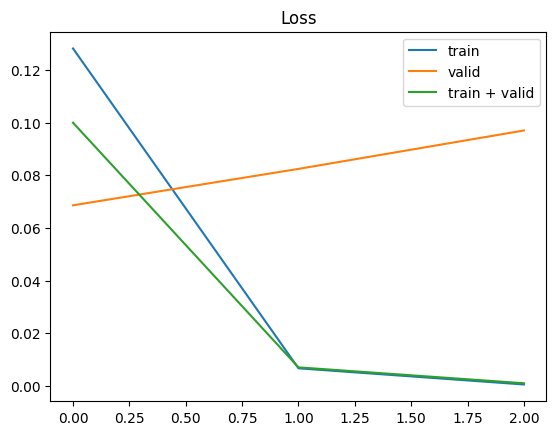

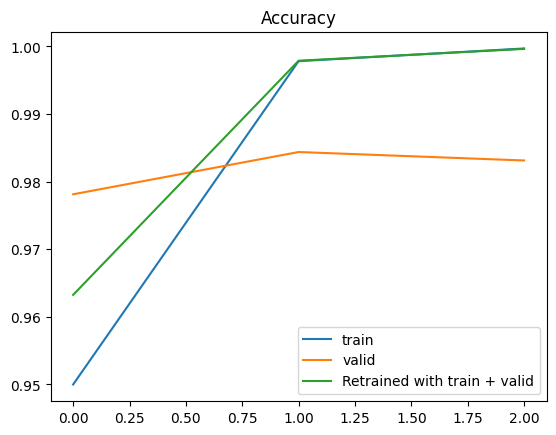

In [128]:
# Evaluate model
print("Checking the results of test dataset.")
test_accu, test_loss = evaluate(test_dataloader)
print("test loss {:8.3f}".format(test_loss))
print("test accuracy {:8.3f}".format(test_accu))

# Predict
def predict(text, text_pipeline):
    with torch.no_grad():
        text = torch.tensor(text_pipeline(text))
        output = model(text, torch.tensor([0]))
        return output.argmax(1).item()
    
ex_text_str = "With regards to your request, we will not be able to provide you with the requested information."
# model = model.to("cpu")
print(
    "This ham email is clasified as %s"
    % ("spam" if predict(ex_text_str, text_pipeline) else "ham")
)

ex_text_str = "You have won a lottery. Please send us your bank account number so we can transfer the money."
print(
    "This spam email is clasified as %s"
    % ("spam" if predict(ex_text_str, text_pipeline) else "ham")
)

# Plot loss
import matplotlib.pyplot as plt
plt.figure(1)
plt.title('Loss')
plt.plot(loss_train, label='train')
plt.plot(loss_val, label='valid')
plt.plot(loss_train_valid, label='train + valid')
plt.legend()

# Plot accuracy
plt.figure(2)
plt.title('Accuracy')
plt.plot(accu_train, label='train')
plt.plot(accu_val, label='valid')
plt.plot(accu_train_valid, label='Retrained with train + valid')
plt.legend()

# Date and time
import datetime
now = datetime.datetime.now().replace(microsecond=0).isoformat()
print(now)

# Export plots to png
plt.figure(1).savefig('figure/loss/' + str(now) + '.png')
plt.figure(2).savefig('figure/accu/' + str(now) + '.png')
plt.show()

In [129]:
if input("Do you want to save the model to progress.md? (y/N) ") == "y":
    comment = input("What was new in this model? ")

    with open("progress.md", "a") as file_object:
        file_object.write("## Model trained on: " + str(now) + "\n\n")
        file_object.write("Comment: **" + comment + "**\n\n")
        file_object.write("Result:\n\n")
        file_object.write("- Test loss: " + str(round(test_loss, 4)) + "\n")
        file_object.write("- Test accuracy: " + str(test_accu) + "\n\n")
        file_object.write("![Loss plot](figure/loss/" + str(now) + ".png)\n")
        file_object.write("![Accuracy plot](figure/accu/" + str(now) + ".png)\n")
        file_object.write("\n")

In [130]:
# Find all miss classified emails in test data
test_data_miss = test_data.copy()
test_data_miss['predict'] = test_data_miss['text'].apply(lambda x: predict(x, text_pipeline))
test_data_miss = test_data_miss[test_data_miss['label'] != test_data_miss['predict']]
test_data_miss.to_csv('miss_classified.csv', index=False)
print("Miss classified emails saved to miss_classified.csv")

# Print percentage of miss classified emails by label
print("Percentage of miss classified emails by label:")
print(test_data_miss['label'].value_counts(normalize=True) * 100)
print("Total miss classified emails: " + str(len(test_data_miss)))


Miss classified emails saved to miss_classified.csv
Percentage of miss classified emails by label:
label
0    57.142857
1    42.857143
Name: proportion, dtype: float64
Total miss classified emails: 14


In [131]:
# Test model on another dataset
# - all data at: other_data/other.csv
# - ham with "Label" 0
# - spam with "Label" 1
# Give accuracy for ham and spam separately
# Give accuracy for all data
# ("spam" if predict(ex_text_str, text_pipeline) else "ham")

# Load data
df = pd.read_csv('other_data/other.csv')
df.head()

# Split data into ham and spam
ham_data = df[df['Label'] == 0]
spam_data = df[df['Label'] == 1]

# Test model on ham
ham_count = 0
i = 0
for _, row in ham_data.iterrows():
    text = row['Body']
    # remove everythin before -seq sel -list
    # text = text.split('-seq sel -list')[1]
    if i == 1:
        print(text)
    i += 1

    print(
        "This ham email is clasified as %s"
        % ("spam" if predict(text, text_pipeline) else "ham")
    )

This ham email is clasified as ham
Martin A posted:
Tassos Papadopoulos, the Greek sculptor behind the plan, judged that the
 limestone of Mount Kerdylio, 70 miles east of Salonika and not far from the
 Mount Athos monastic community, was ideal for the patriotic sculpture. 
 
 As well as Alexander's granite features, 240 ft high and 170 ft wide, a
 museum, a restored amphitheatre and car park for admiring crowds are
planned
---------------------
So is this mountain limestone or granite?
If it's limestone, it'll weather pretty fast.------------------------ Yahoo! Groups Sponsor ---------------------~-->
4 DVDs Free +s&p Join Now
http://us.click.yahoo.com/pt6YBB/NXiEAA/mG3HAA/7gSolB/TM
---------------------------------------------------------------------~->To unsubscribe from this group, send an email to:
forteana-unsubscribe@egroups.com Your use of Yahoo! Groups is subject to http://docs.yahoo.com/info/terms/ 
This ham email is clasified as spam
This ham email is clasified as spam
This 